# Flux processing: Example

This notebook contains an example of the flux calculation procedure done in Sáez-Leiva et al., (in review). SR_1 data is used.
Please note that this example is customized for a plane with normal (1,0,0). However, it can be modified for a generic plane modifying this notebook and the FluxProcessing.py script.

First, we import the libraries used in this calculation, including the FluxProcessing module. We also define the raw_data path, as well as the results path.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import matplotlib.lines as mlines
from scipy.interpolate import griddata
import FluxProcessing as fp
from tqdm import notebook

input_path = 'models/raw_data/'
output_path = 'models/processed_data/'

In this example we use slice data at every time step, from the Darcy velocity field of the model SR_1. This slice, which correspond to the selected area in Figure 5f of the article, consist of a plane located at x = 8000 mts, and with a domain defined in y $\in$ (-3500, -1500) mts and z $\in$ (-5000,-2000) mts. 

We proceed to load the files and filter duplicated points that could be generated creating the slice.

In [8]:
for i in notebook.tnrange(269,desc='File filtering'):
    file = 'fluxovertime__' + str(i)
    fluxes = np.loadtxt(input_path+file+'.txt',delimiter=',',skiprows=1)
    # Filter data to delete duplicated values
    fluxes_filtered = []
    for i in range(np.size(fluxes[:,1])):
        point = fluxes[i,[3,4,5]]
        if i == 0:
            fluxes_filtered.append(fluxes[i,:])
            continue
        elif np.array_equiv(point,fluxes[i-1,[3,4,5]]):
            continue
        else:
            fluxes_filtered.append(fluxes[i,:])
    
    fluxes_filtered = np.array(fluxes_filtered)
    
    np.savetxt(input_path+file+'_Filtered.txt',fluxes_filtered)

File filtering:   0%|          | 0/269 [00:00<?, ?it/s]

As result, the previous loop creates filtered versions of the slices data. With this filtered files, we proceed to calculate the flux integral using the FluxProcessing module. A np.array(), saved in a txt, containing the flux integral at each time step is the output of this loop. A grid is previously created to do the calculation.

In [10]:
grid_y, grid_z = np.mgrid[-1500:-3500:1500j, -2000:-5000:1500j]
dAreas = fp.dA(grid_y, grid_z)

flux_overtime = []
for i in notebook.tnrange(269,desc='Calculating Flux...'):
    file = input_path + 'fluxovertime__' + str(i) + '_Filtered.txt'
    fluxes_filtered = np.loadtxt(file)
    flux = griddata(fluxes_filtered[:,[4,5]], fluxes_filtered[:,0], (grid_y, grid_z), method='cubic')
    flux_overtime.append(fp.flux_integral(grid_y,grid_z,flux,dAreas))
np.savetxt(output_path+'FluxVariation.txt',np.array(flux_overtime))

Calculating Flux...:   0%|          | 0/269 [00:00<?, ?it/s]

Finally, we plot our results using a snippet from the flux_plotter notebook (see this notebook for more details).

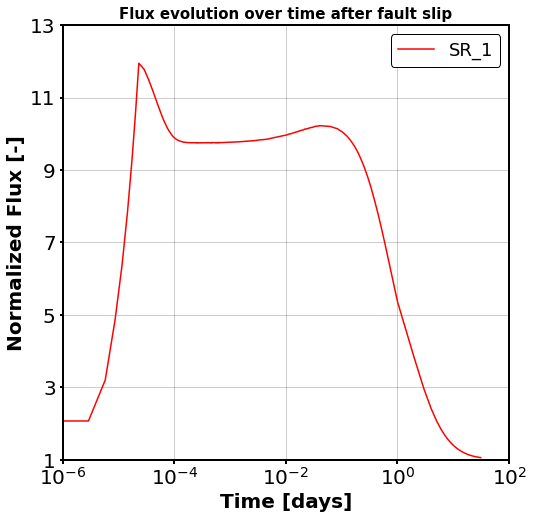

In [12]:
times_1 = np.loadtxt('models/timesteps_SR_1.txt')
flux = np.loadtxt(output_path+'FluxVariation.txt')

times_1 = times_1[17:,4]
flux = flux[17:]/flux[17]

legend_elements = [mlines.Line2D([0],[0],color='red',label='SR_1')]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_yticks([1,3,5,7,9,11,13],minor=False)
ax.grid(True, which="major", ls="-", lw=1, color='k',alpha=0.2)
ax.grid(True, which="minor", ls="-", alpha = 0.05)
ax.plot(times_1,flux,'red')
ax.set_xscale('log')
ax.set_xticks([1e-6,1e-4,1e-2,1e0,1e2],minor=False)
ax.set_xlabel('Time [days]',fontsize=20,fontweight='bold')
ax.set_ylabel('Normalized Flux [-]',fontsize=20,fontweight='bold')
ax.set_title('Flux evolution over time after fault slip',fontsize=15,fontweight='bold')
ax.set_xlim(1e-6,1e2)
ax.set_ylim(1,13)
ax.tick_params(width=2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(axis='both', labelsize=20)
ax.legend(handles = legend_elements, loc = 1, ncol = 1,fontsize=18,framealpha=1,edgecolor='k')